<p><img alt="Colaboratory logo" width="170" height="120" src="https://www.kaggle.com/competitions/73231/images/header" align="left" hspace="15px" ></p>


<h1>AI Mathematical Olympiad </h1>

----


<div align="left">
<font size=3>
Exploratory Data Analysis<br>
  
</font>
</div>


In [13]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
# from tqdm.notebook import tqdm
# tqdm.pandas()


from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

## Data mining




For Exploration and Data Analysis (EDA), we have collected and filtered data from several datasets such as AIMO External Dataset, MATH Dataset, GSM8K, Math QSA Dataset and MathQA. 

In [15]:
# Read all the Data Frames and work with them

# if working in Kaggle replace ../Data with /kaggle/input

# -- Math QSA --
df_1 = pd.read_csv("../Data/math-qsa-dataset/test.csv")
df_2 = pd.read_csv("../Data/math-qsa-dataset/train.csv")
df_MQSA = pd.concat([df_1, df_2])

# -- GSM8K --                
df_3 = pd.read_json("../Data/gsm8k-dataset/test.jsonl",lines=True)
df_4 = pd.read_json("../Data/gsm8k-dataset/train.jsonl",lines=True)

# -- Dataset for solving math --
df_5 = pd.read_csv("../Data/dataset-for-solving-math-word-problems/test.csv")
df_6 = pd.read_csv("../Data/dataset-for-solving-math-word-problems/train.csv")

# -- Aimo external Dataset --
df_7 = pd.read_csv("../Data/aimo-external-dataset/external_df.csv", sep=',')

# We keep the format problem / solution / answer

Format the dataframes keeping the same format

| **Column** | **Description** | 
| ------------- | ------------- |
| problem | Text with the mathematical problem statement |
| solution | Text with the mathematical step by step problem solution |
| answer | Numerical value, final solution |


In [17]:
# We keep the format problem / solution / answer
df_1 = df_1[['problem', 'solution', 'answer']]
df_2 = df_2[['problem', 'solution', 'answer']]

# The format of the answer of --GSM8K-- Dataset is a detail solution of the problem and the answer to the final

# Rename columns to keep the format
df_3.rename(columns={'question':'problem', 'answer':'solution'}, inplace=True)
df_4.rename(columns={'question':'problem', 'answer':'solution'}, inplace=True)

# Scrap the answers 
df_3['answer'] = df_3['solution'].apply(str.split).apply(lambda x: x[-1])
df_4['answer'] = df_4['solution'].apply(str.split).apply(lambda x: x[-1])

In [295]:
# Scrap the correct answer of the --Dataset for Math solving--"
# Every answer correspond to an option list as a), b), c), d), e)

df_5 = pd.concat([df_5, df_6]) # Both Datasets of Math Solving

def obtener_primer_numero(lista):
    return [x.split()[0] for x in lista if x.split()]

index_answer = {'a':0,'b':1, 'c':2, 'd':3, 'e':4} # Position of the answer in the list of answers

df_5[~df_5['options'].str.contains(':')] # Delete some false positives answers (Problems of ratio type)

# Filter of the answers
df_5['answer'] = df_5['options'].apply(lambda x:x.replace(')', '')
                                .replace('min', '')
                                .replace('m', '')
                                .replace('cm', '')
                                .replace('a', '')
                                .replace('b', '')
                                .replace('c', '')
                                .replace('d', '')
                                .replace('e', '')
                                .replace('hours', '')).str.split(',').apply(obtener_primer_numero)

df_5 = df_5[df_5['answer'].apply(len) == 5] # Impute bad leaks

# -- Filter index of the correct answer --
df_5['correct'] = df_5['correct'].map(index_answer) # mapping of the answer to an index
df_5['answer'] = df_5.apply(lambda row: row['answer'][row['correct']], axis=1) # mapping the correct answer from the previous filter
df_5.reset_index(drop=True, inplace=True)

df_5.rename(columns={'Problem':'problem', 'Rationale':'solution'}, inplace=True)

# Solution format with given solution structure
df_5['solution'] = df_5['solution'] +'.\nthe following formula was used for this problem: ' + df_5['annotated_formula']
df_5.loc[0, 'problem']

# problem / solution / answer
df_5 = df_5[['problem', 'solution', 'answer']]

In [19]:
# For the AIMO external Dataset the answer for some problems is the last thing of the solution being boxed (in LaTeX)
patron = r'boxed\{(.*?)\}' # Use the patron to have the answer of each problem

# Problem with boxed solutions
df_7['answer'] = df_7.apply(lambda row: re.findall(patron, row['solution']),axis=1) # Apply regular expression
df_7_1 = df_7[df_7['answer'].apply(len) != 0]
df_7_1['answer'] = df_7_1['answer'].apply(lambda row: row[-1])

# Problem with boxed solutions other way
df_7_2 = df_7[df_7['answer'].apply(len) == 0]
df_7_2['answer'] = df_7_2['solution'].apply(lambda x: x.split()[-1])

df_7 = pd.concat([df_7_2, df_7_1]).reset_index(drop=True)[['problem', 'solution', 'answer']]

Save Dataframe

In [21]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_7], axis=0).reset_index(drop=True)
df.to_csv('../Data/AIMO_data.csv')

In [310]:
df.shape

(56844, 3)

In [312]:
df.sample(5)

,problem,solution,answer
20644,a garrison of 1000 men has provisions for 60 d...,"""1000 - - - - 60 1000 - - - - 45 x - - - - - 2...",1250
4993,Ten chairs are arranged in a circle. Find the ...,We know that a subset with less than $3$ chair...,581
56452,"When $A$ is doubled, the new value is 10 more ...",We have $2A=A+10\Rightarrow 2A-A=10\Rightarrow...,10
25476,"when 1 / 10 percent of 4,000 is subtracted fro...","""we can break this problem into two parts : 1 ...",396
366,"In my neighborhood, there are six streets. The...",There are 2 sides to each street with 10 house...,120


In [299]:
df.drop(df[df.isnull().any(axis=1)].index, inplace = True)

Some analytics for the MQSA


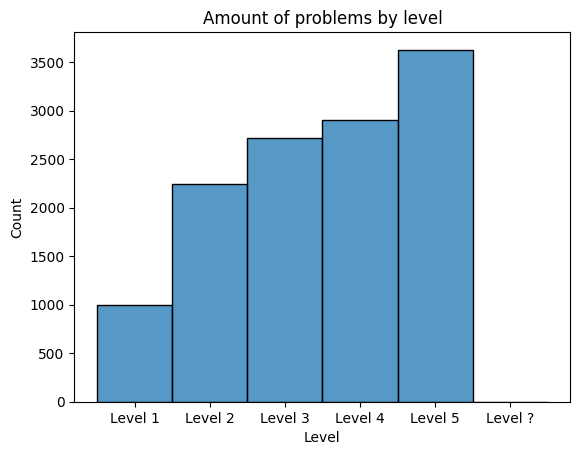

In [302]:
order = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level ?']
sns.histplot(data=df_MQSA.sort_values(by='level'), x='level', hue_order=order)
plt.title('Amount of problems by level')
plt.xlabel('Level')
plt.show()

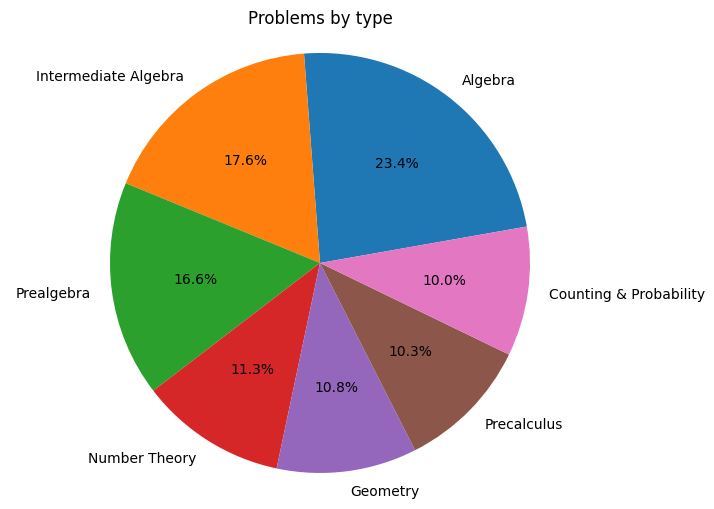

In [303]:
type_counts = df_MQSA['type'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=10)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Problems by type')
plt.show()

TypeError: expected string or bytes-like object

Configuration

In [12]:
from app.utils.conf import CFG

Filter, the problems for this competition have answers with non negative integers

In [309]:
def is_integer(text):
    try:
        if int(text)>= 0:
            return True
        else:
            return False
    except ValueError:
        return False
    
df["is_integer"] = df.answer.map(is_integer)
df = df[df['is_integer']].reset_index(drop=True)
df.drop(columns=['is_integer'], inplace=True)
df.sample(2)

,problem,solution,answer
24562,a 14 cm long wire is to be cut into two pieces...,"""1 : 2 / 5 = 5 : 2 2 / 7 * 14 = 4 answer : e""....",4
43361,Marissa is serving her kids lunch. Each kid ge...,First figure out how many total calories come ...,5
